# Loading required packages

In [8]:
from datetime import datetime, timedelta
import numpy as np
import pickle
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 0)

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

RANDOM_STATE = 1

# Loading relevant data for scoring

In [9]:
data_dictionary = pd.read_excel('Data Dictionary.xls', header=1)
data_dictionary

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


In [10]:
sample_entry = pd.read_csv('sampleEntry.csv')
sample_entry

,Id,Probability
0,1,0.080807
1,2,0.040719
2,3,0.011968
3,4,0.067640
4,5,0.108264
...,...,...
101498,101499,0.045363
101499,101500,0.343775
101500,101501,0.006970
101501,101502,0.121994


In [11]:
train_data = pd.read_csv('cs-training.csv', index_col=0)
train_data.head(3)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0


In [12]:
test_data = pd.read_csv('cs-test.csv', index_col=0)
test_data.head(3)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0


# Relevant preprocessing and insights

## Segregating independent and dependent variable

In [13]:
train_data.shape

(150000, 11)

In [14]:
# default column
def_col = 'SeriousDlqin2yrs'
pred_col = list(set(train_data.columns.tolist()) - set([def_col]))
pred_col

['age',
 'MonthlyIncome',
 'NumberOfTimes90DaysLate',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfDependents',
 'NumberRealEstateLoansOrLines',
 'NumberOfOpenCreditLinesAndLoans',
 'DebtRatio',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'RevolvingUtilizationOfUnsecuredLines']

In [15]:
train_data[def_col].value_counts()

0    139974
1    10026 
Name: SeriousDlqin2yrs, dtype: int64

In [16]:
def_percent = round(train_data[def_col].mean()*100, 2)
print(f"{def_percent}%")

6.68%


## Data types

In [17]:
train_data.dtypes

SeriousDlqin2yrs                        int64  
RevolvingUtilizationOfUnsecuredLines    float64
age                                     int64  
NumberOfTime30-59DaysPastDueNotWorse    int64  
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans         int64  
NumberOfTimes90DaysLate                 int64  
NumberRealEstateLoansOrLines            int64  
NumberOfTime60-89DaysPastDueNotWorse    int64  
NumberOfDependents                      float64
dtype: object

In [18]:
num_unq_vals = {}
for col in pred_col:
    num_unq_vals[col] = train_data[col].nunique()

pd.DataFrame(num_unq_vals, index=['Number of Unique Values']).T

,Number of Unique Values
age,86
MonthlyIncome,13594
NumberOfTimes90DaysLate,19
NumberOfTime30-59DaysPastDueNotWorse,16
NumberOfDependents,13
NumberRealEstateLoansOrLines,28
NumberOfOpenCreditLinesAndLoans,58
DebtRatio,114194
NumberOfTime60-89DaysPastDueNotWorse,13
RevolvingUtilizationOfUnsecuredLines,125728


# Learnings
- All features are continuous

## Missing value rates for independent variables

In [19]:
fillrate_df = pd.DataFrame(train_data[pred_col].count()/train_data.shape[0] * 100).rename(columns={0: 'fillrate'})
fillrate_df['counts'] = train_data[pred_col].count()
fillrate_df.style.background_gradient()

,fillrate,counts
age,100.000000,150000
MonthlyIncome,80.179333,120269
NumberOfTimes90DaysLate,100.000000,150000
NumberOfTime30-59DaysPastDueNotWorse,100.000000,150000
NumberOfDependents,97.384000,146076
NumberRealEstateLoansOrLines,100.000000,150000
NumberOfOpenCreditLinesAndLoans,100.000000,150000
DebtRatio,100.000000,150000
NumberOfTime60-89DaysPastDueNotWorse,100.000000,150000
RevolvingUtilizationOfUnsecuredLines,100.000000,150000


In [20]:
dpd_columns = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']

In [21]:
train_data[(train_data['NumberOfTime30-59DaysPastDueNotWorse'] == 0) & (train_data['NumberOfTime60-89DaysPastDueNotWorse'] != 0)].shape[0]/train_data[train_data['NumberOfTime30-59DaysPastDueNotWorse'] == 0].shape[0]

0.02548048691456776

In [22]:
train_data[(train_data['NumberOfTime30-59DaysPastDueNotWorse'] == 0) & (train_data['NumberOfTimes90DaysLate'] != 0)].shape

(3989, 11)

In [23]:
24000/150000

0.16

In [24]:
train_data[dpd_columns].mean()

NumberOfTime30-59DaysPastDueNotWorse    0.421033
NumberOfTime60-89DaysPastDueNotWorse    0.240387
NumberOfTimes90DaysLate                 0.265973
dtype: float64

In [25]:
train_data[train_data['NumberOfTime30-59DaysPastDueNotWorse'] > 0][dpd_columns]

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate
1,2,0,0
3,1,0,1
5,1,0,0
14,3,1,3
30,2,0,0
...,...,...,...
149957,2,0,0
149962,1,0,1
149975,2,0,0
149979,2,0,0


# Learnings:
- monthly income is missing for approximately 20% of the customers
- number of dependents is missing for about 2.6% of the customers

## Distributions of the independent variables

In [26]:
train_data[pred_col].describe(percentiles=[i/10 for i in range(11)]).T[['0%', '10%', '20%', '30%', '40%', '50%',
       '60%', '70%', '80%', '90%', '100%']]

,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
age,0.0,33.000000,39.000000,44.000000,48.000000,52.000000,56.000000,61.000000,65.000000,72.000000,109.0
MonthlyIncome,0.0,2005.000000,3000.000000,3800.000000,4544.200000,5400.000000,6300.000000,7500.000000,9083.000000,11666.000000,3008750.0
NumberOfTimes90DaysLate,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.0
NumberOfTime30-59DaysPastDueNotWorse,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,98.0
NumberOfDependents,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,20.0
NumberRealEstateLoansOrLines,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,54.0
NumberOfOpenCreditLinesAndLoans,0.0,3.000000,4.000000,5.000000,6.000000,8.000000,9.000000,10.000000,12.000000,15.000000,58.0
DebtRatio,0.0,0.030874,0.133773,0.213697,0.287460,0.366508,0.467506,0.649189,4.000000,1267.000000,329664.0
NumberOfTime60-89DaysPastDueNotWorse,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.0
RevolvingUtilizationOfUnsecuredLines,0.0,0.002969,0.019222,0.043461,0.083181,0.154181,0.271493,0.445136,0.698857,0.981278,50708.0


# Observations

- We can see that the more than 20% of the users have ***DebtRatio*** greater than or equal to 4. This means that such people are earning 4 times less than the debt they have accrued. This is an indicator for people not being able to afford/pay their debts on time. Higher delinquency rates might be observed in such users and this is worth investigating.
- Similarly, we can see that the max value of ***RevolvingUtilizationOfUnsecuredLines*** is 50708, indicating that this user's consumption of a credit product (say a credit card) is 50708 times the credit limit offered by that credit product!!! Moreover this goes on to show that there is a set of users for whom this value is greater than 1 (which is odd), which is worth looking into.

### Investigating DebtRatio

In [27]:
train_data[train_data['DebtRatio'] > 1].shape

(35137, 11)

In [28]:
train_data.groupby(train_data['DebtRatio'] > 1)[def_col].mean()*100

DebtRatio
False    6.734109
True     6.520192
Name: SeriousDlqin2yrs, dtype: float64

- We see that the delinquency rates don't differ much in these 2 groups. So maybe our hypothesis is wrong. We can check the monthly income for those whose ***DebtRatio*** is greater than 1.

In [29]:
train_data[(train_data['DebtRatio'] > 1)][['DebtRatio', 'MonthlyIncome']].MonthlyIncome.value_counts(dropna=False, normalize=True)*100

NaN       79.414862
0.0       4.328770 
1.0       1.588070 
2500.0    0.480974 
2000.0    0.406978 
            ...    
2558.0    0.002846 
4170.0    0.002846 
1866.0    0.002846 
2785.0    0.002846 
9125.0    0.002846 
Name: MonthlyIncome, Length: 1897, dtype: float64

In [30]:
train_data.groupby((train_data['DebtRatio'] > 1) & (train_data['MonthlyIncome'].notna())).agg({def_col: ['count', 'mean']})

SeriousDlqin2yrs          
                 count      mean
False  142767           0.065092
True   7233             0.101341

- Most of the users with hgih ***DebtRatio*** don't have ***MonthlyIncome*** present. We can hypothesise that during the calculation of this value, maybe there was some low default value imputation resulting in high ***DebtRatio*** values.
- Here we clearly see that users whose ***DebtRatio*** is greater than 1 with ***MonthlyIncome*** present have very high delinquency rates compared to that of the whole population. Hence we can create a flag feature for users with High *DebtRatio* and *MonthlyIncome* present.

In [31]:
train_data['HighDebtIncomePresent'] = np.where((train_data['DebtRatio'] > 1) & (train_data['MonthlyIncome'].notna()), 1, 0)
test_data['HighDebtIncomePresent'] = np.where((test_data['DebtRatio'] > 1) & (test_data['MonthlyIncome'].notna()), 1, 0)

In [32]:
pred_col.append('HighDebtIncomePresent')

### Investigating RevolvingUtilizationOfUnsecuredLines

In [33]:
train_data[train_data['RevolvingUtilizationOfUnsecuredLines'] > 1].shape[0]/ train_data.shape[0] *100

2.214

In [34]:
train_data.groupby(train_data['RevolvingUtilizationOfUnsecuredLines'] > 1).agg({def_col: ['count', 'mean']})

SeriousDlqin2yrs          
                                                count      mean
RevolvingUtilizationOfUnsecuredLines                           
False                                 146679           0.059920
True                                  3321             0.372478

- Clearly the delinquency rates of users with ***RevolvingUtilizationOfUnsecuredLines*** > 1 (37.2%) is much greater than those whose corresponding value is less than 1.
- Hence we create a flag feature for such users.
- We can hypothesise that such users must have defaulted on their payments due to which their credit limits might have been reduced. Hence the bureau might have reported the latest credit limit of the person while reporting their average monthly bills, which would explain the hgih credit utilisation values.

In [35]:
train_data['VeryHighCreditUtilisation'] = np.where(train_data['RevolvingUtilizationOfUnsecuredLines'] > 1, 1, 0)
test_data['VeryHighCreditUtilisation'] = np.where(test_data['RevolvingUtilizationOfUnsecuredLines'] > 1, 1, 0)

pred_col.append('VeryHighCreditUtilisation')

In [36]:
train_data[pred_col].describe(percentiles=[i/10 for i in range(1, 10)]).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
age,150000.0,52.295207,14.771866,0.0,33.000000,39.000000,44.000000,48.000000,52.000000,56.000000,61.000000,65.000000,72.000000,109.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,2005.000000,3000.000000,3800.000000,4544.200000,5400.000000,6300.000000,7500.000000,9083.000000,11666.000000,3008750.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,98.0
NumberOfDependents,146076.0,0.757222,1.115086,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,20.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,54.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,3.000000,4.000000,5.000000,6.000000,8.000000,9.000000,10.000000,12.000000,15.000000,58.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.030874,0.133773,0.213697,0.287460,0.366508,0.467506,0.649189,4.000000,1267.000000,329664.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.002969,0.019222,0.043461,0.083181,0.154181,0.271493,0.445136,0.698857,0.981278,50708.0


## Boxplots of independent variables with the dependent variable

In [37]:
train_data[pred_col].dtypes

age                                     int64  
MonthlyIncome                           float64
NumberOfTimes90DaysLate                 int64  
NumberOfTime30-59DaysPastDueNotWorse    int64  
NumberOfDependents                      float64
NumberRealEstateLoansOrLines            int64  
NumberOfOpenCreditLinesAndLoans         int64  
DebtRatio                               float64
NumberOfTime60-89DaysPastDueNotWorse    int64  
RevolvingUtilizationOfUnsecuredLines    float64
HighDebtIncomePresent                   int64  
VeryHighCreditUtilisation               int64  
dtype: object

/var/folders/2t/kws3z2h52bl_tmtkx1j12xnw0000gn/T/ipykernel_86156/4142865582.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

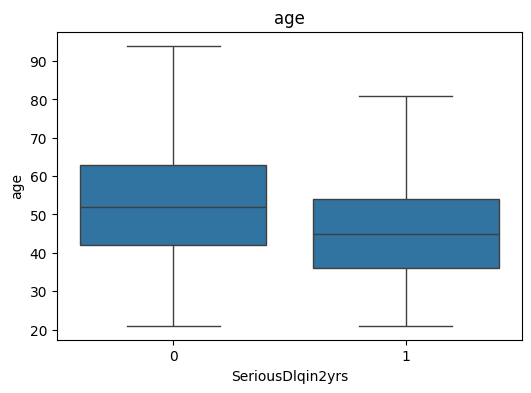

<Figure size 640x480 with 0 Axes>

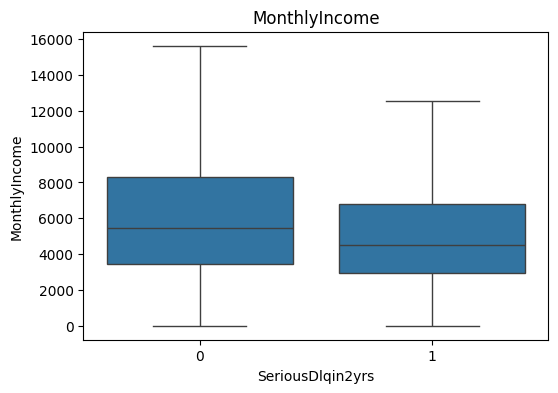

<Figure size 640x480 with 0 Axes>

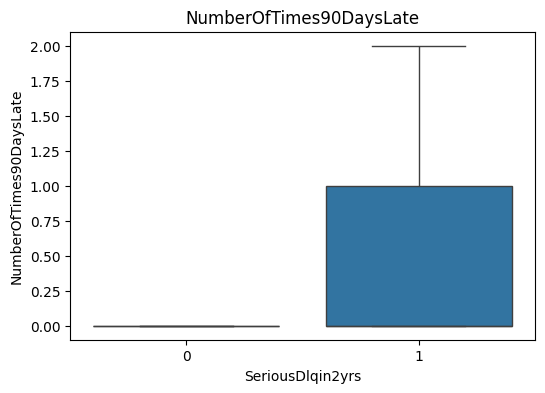

<Figure size 640x480 with 0 Axes>

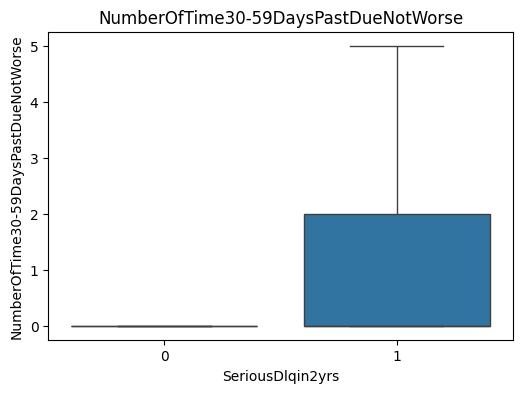

<Figure size 640x480 with 0 Axes>

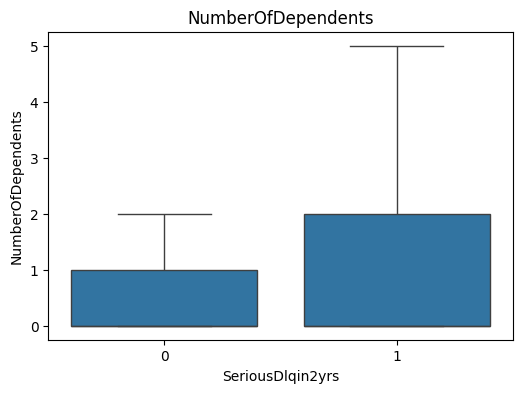

<Figure size 640x480 with 0 Axes>

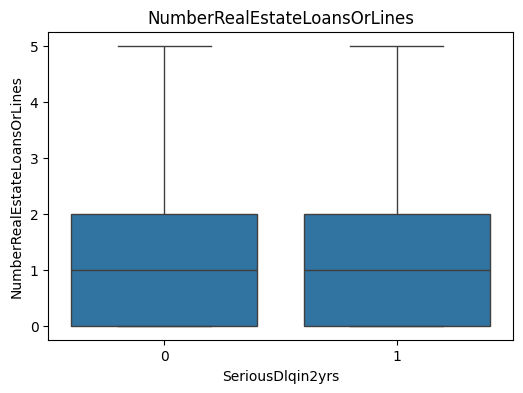

<Figure size 640x480 with 0 Axes>

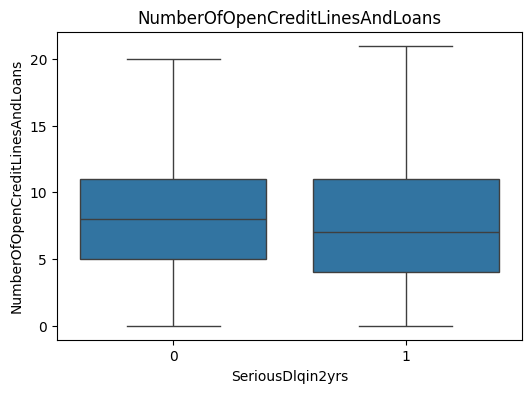

<Figure size 640x480 with 0 Axes>

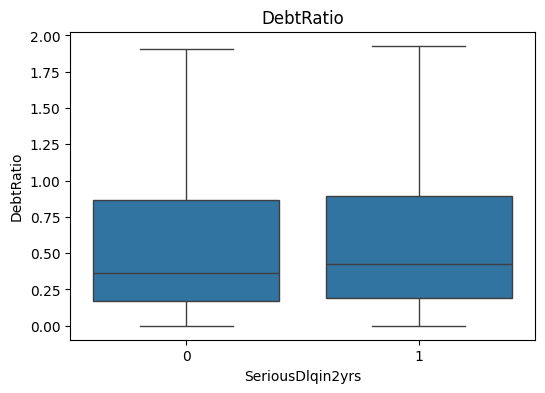

<Figure size 640x480 with 0 Axes>

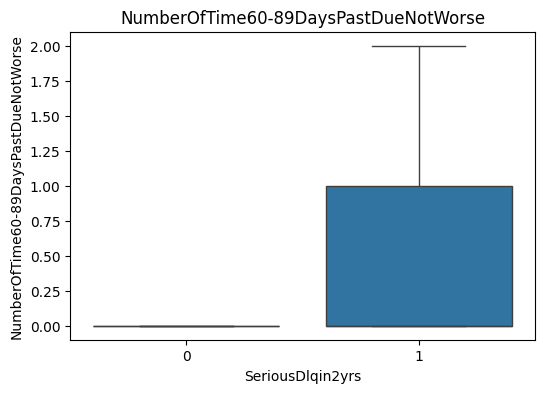

<Figure size 640x480 with 0 Axes>

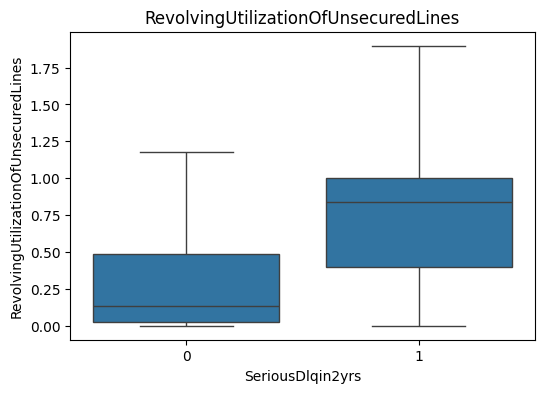

<Figure size 640x480 with 0 Axes>

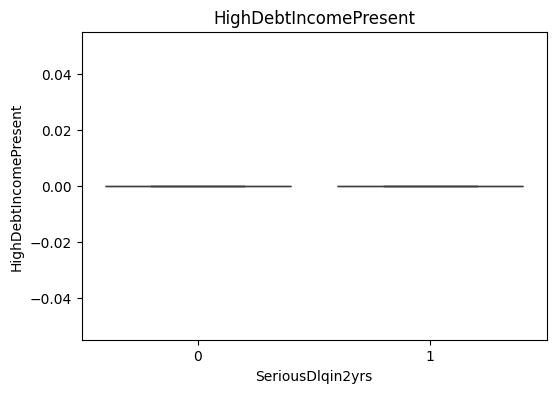

<Figure size 640x480 with 0 Axes>

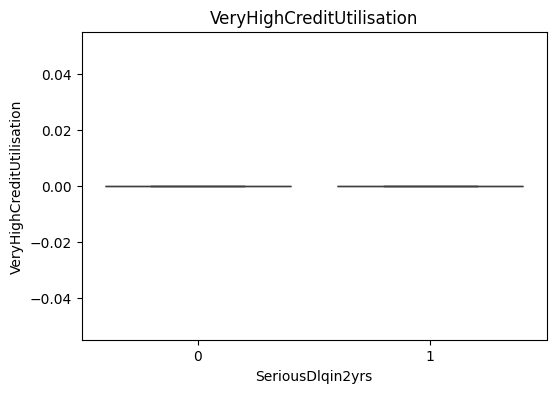

In [38]:
for i in pred_col:
    plt.figure()
    # plt.tight_layout()
    # sns.set(rc={"figure.figsize":(8, 4)})
    fig, ax = plt.subplots(figsize=(6,4))
    sns.boxplot(x=def_col, y=i, data=train_data , linewidth=1.0, showfliers=False, ax=ax).set_title(i)

# Learnings:
## (from boxplots with outliers removed)
- Delinquency reduces slightly as income increases
- Delinquency increases with number of dependents
- Number of loan products doesn't seem to affect delinquency
- Neither does debt ratio
- Delinquency decreases slightly with age
- Number of real estate loans doesn't seem to affect delinquency
- Delinquency increases with increase in unsecured loan utilization

## Correlation heatmap of independent variables

<Axes: >

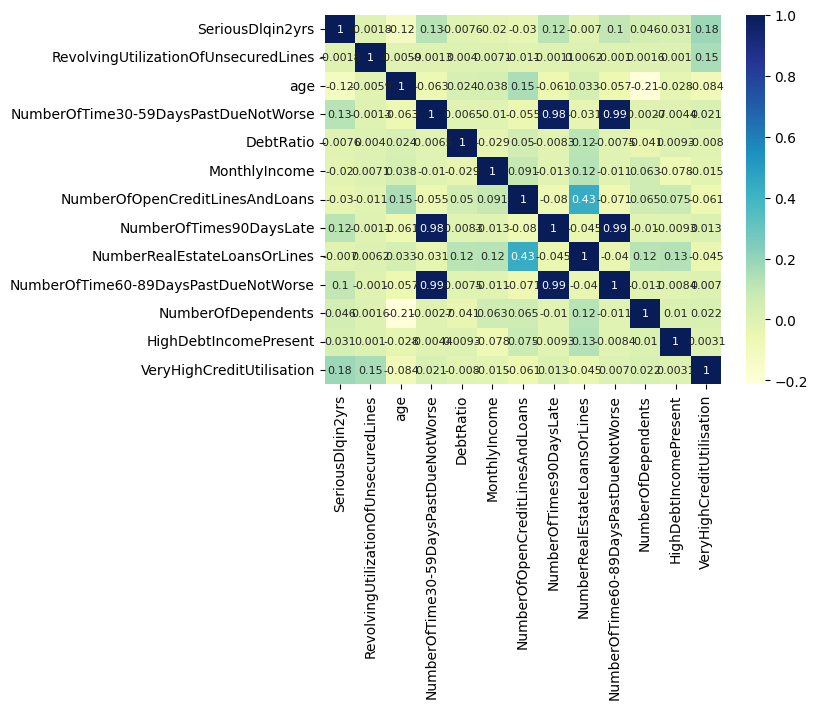

In [39]:
sns.heatmap(train_data.corr(), cmap="YlGnBu", annot=True, annot_kws={'fontsize': 8})

# Learnings:
## (from correlation heatmap)
- As we can see the dpd columns are very highly correlated
- Number of open credit lines and loans is correlated to some extent with the number of real estate loans and credit lines
- Rest of the variables don't show significant correlations

## Equi-frequency plots of independent variables with trend of dependent variables

In [40]:
def get_equi_frequency_plot(data, features, col_target):
    if not features:
        features = data.columns.tolist()

    # print('Total number of columns to calculate: {}'.format(len(features)))

    for col_name in features:
        # print(col_name)
        if str(data[col_name].dtypes) != 'object':
            percentiles = [x/20 for x in range(21)]

            def f(x, desc):
                if str(x) == 'nan':
                    return -100000
                percentiles = ['0%', '5%', '10%', '15%', '20%', '25%', '30%',
                               '35%', '40%', '45%', '50%', '55%', '60%', '65%',
                               '70%', '75%', '80%', '85%', '90%', '95%', '100%']
                for each in percentiles:
                    if x <= desc[each]:
                        return desc[each]

            desc = data[col_name].describe(percentiles)
            data['equi_frequency_bracket'] = data[col_name].apply(lambda x: f(x, desc))
            b = data.groupby('equi_frequency_bracket').agg({col_target: 'mean', 'equi_frequency_bracket': 'count'}).rename(columns={'equi_frequency_bracket': 'count'})
            b = b.rename(index={-100000.0: 'nan'})
            b.reset_index(inplace=True)
            b['equi_frequency_bracket'] = b['equi_frequency_bracket'].apply(lambda x: round(x, 5) if str(x)!='nan' else x) 
            b['equi_frequency_bracket'] = b['equi_frequency_bracket'].astype(str)
            
            fig, ax1 = plt.subplots()
            ax2 = ax1.twinx()
            ax1.bar(b['equi_frequency_bracket'], b['count'], label='Count', color='cornflowerblue')
            ax2.plot(b['equi_frequency_bracket'], b[col_target], label=col_target, color='dimgray')            
            ax2.set_xlabel('equi_frequency_bracket')
            ax2.set_ylabel(col_target)
            ax1.set_ylabel('Count')
            ax1.grid(linestyle='dashed')
            fig.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
            plt.title(col_name)
            for ax in fig.axes:
                plt.sca(ax)
                plt.xticks(rotation=90)
            plt.show()
            data = data.drop('equi_frequency_bracket', axis=1)

        else:
            print(f"Cannot plot for: \'{col_name}\' because it\'s a object type column.")



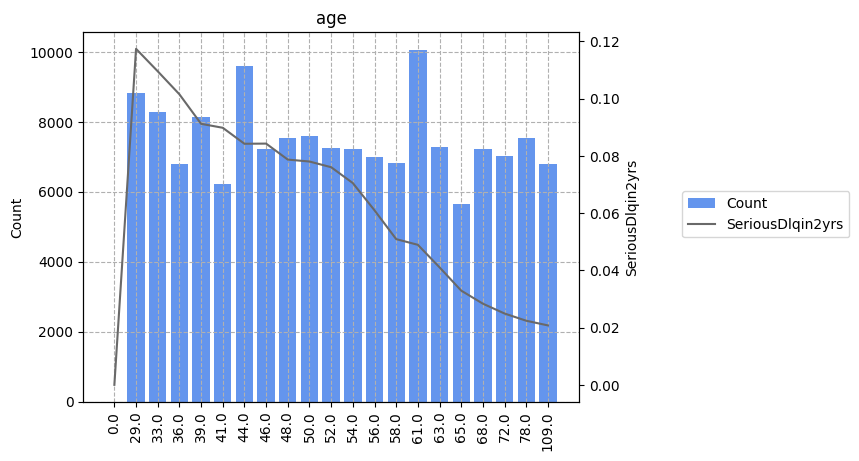

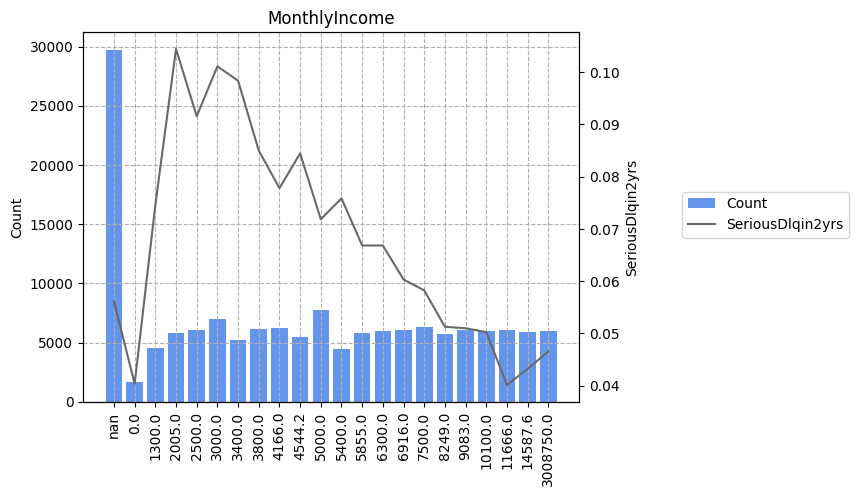

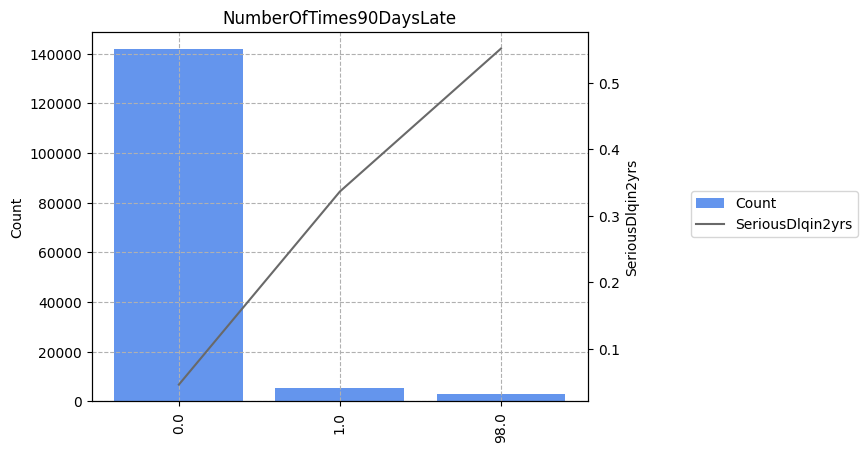

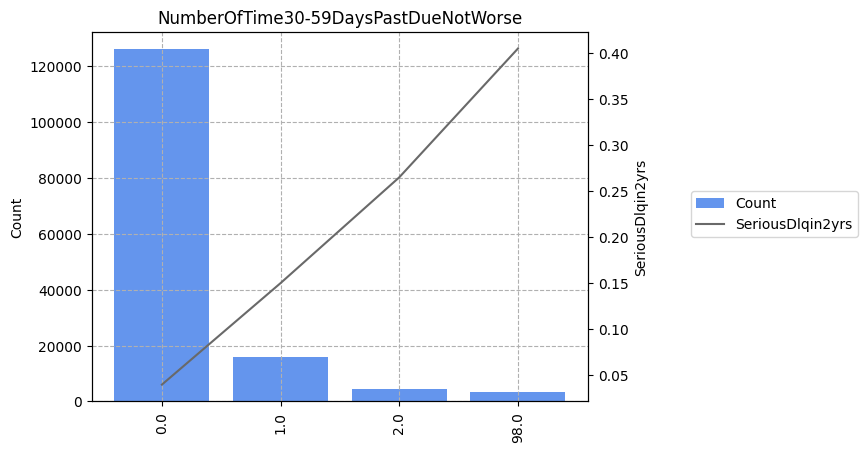

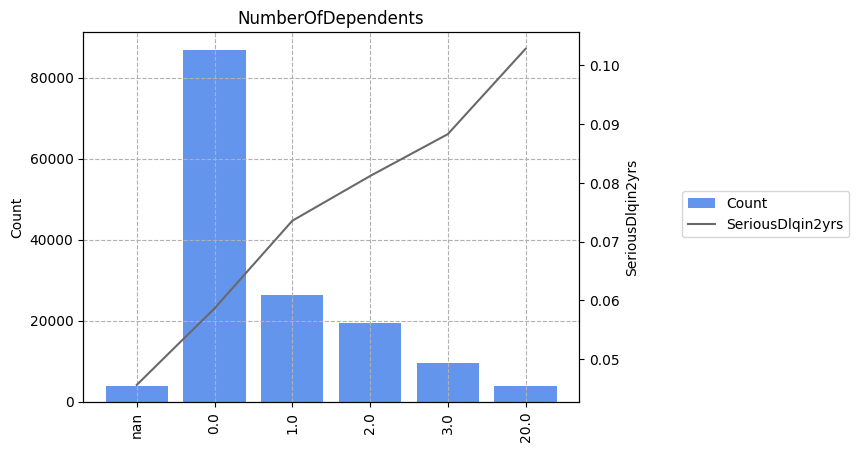

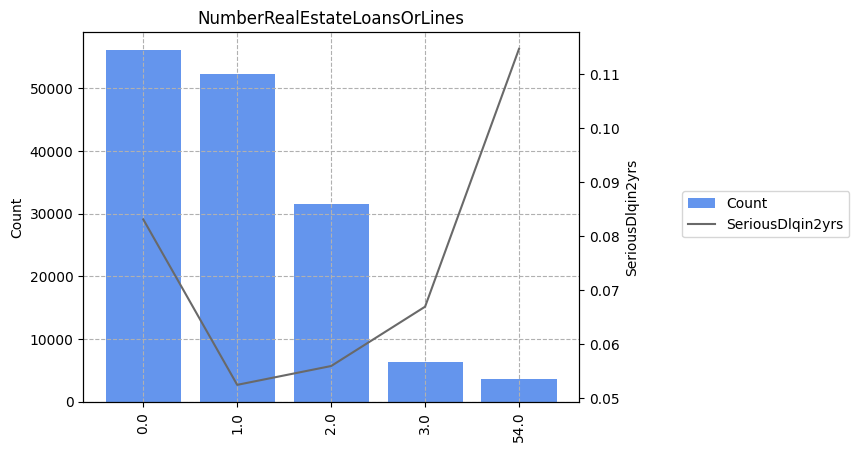

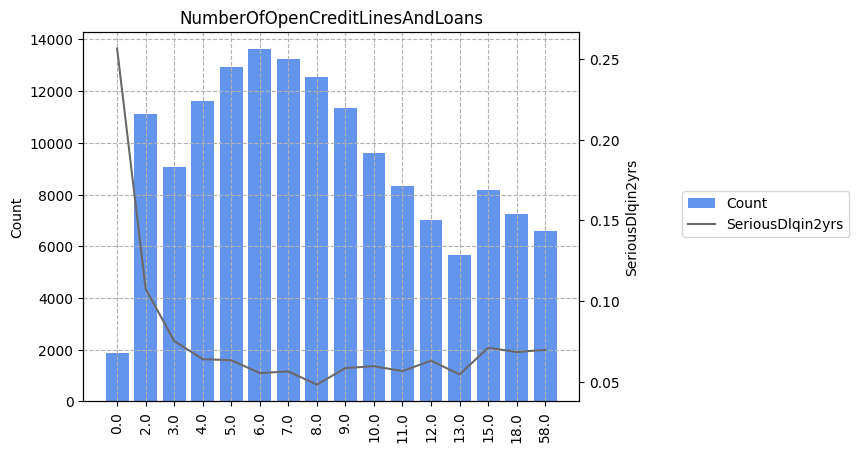

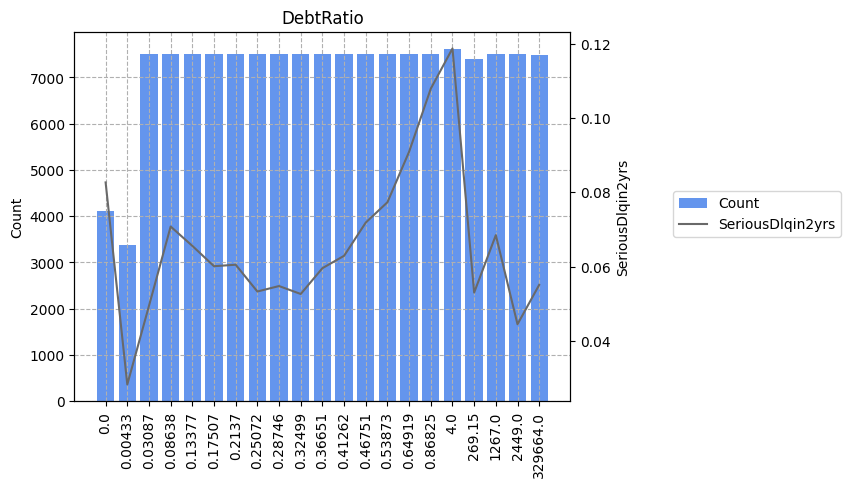

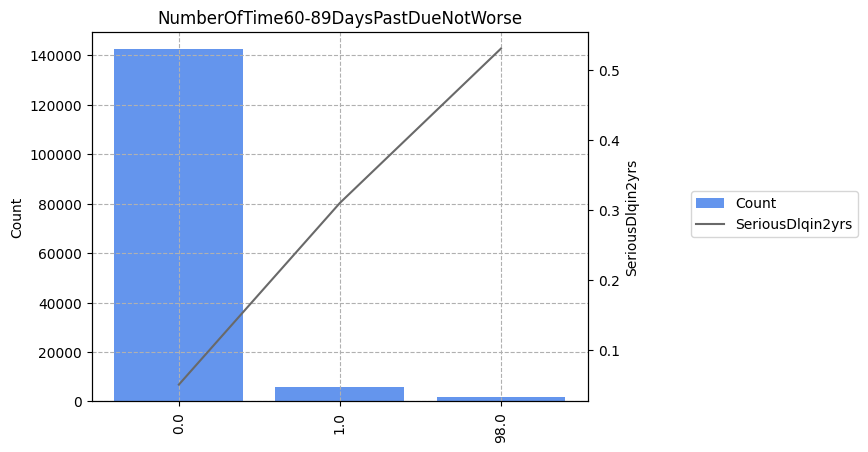

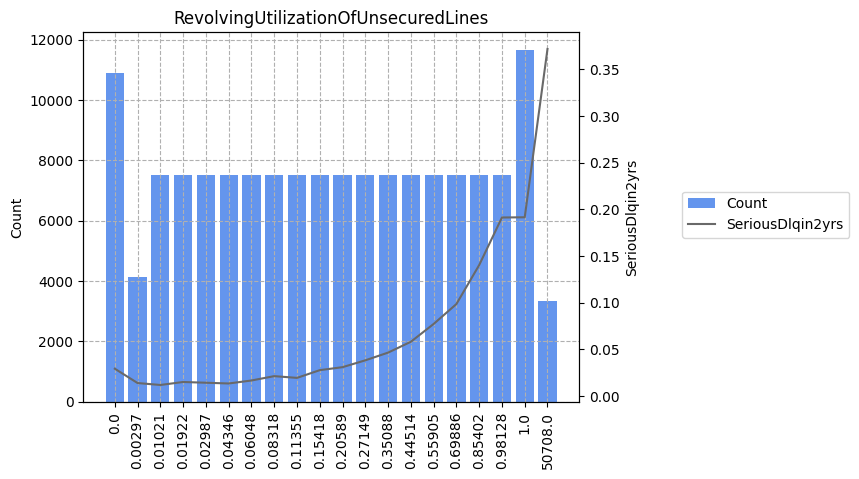

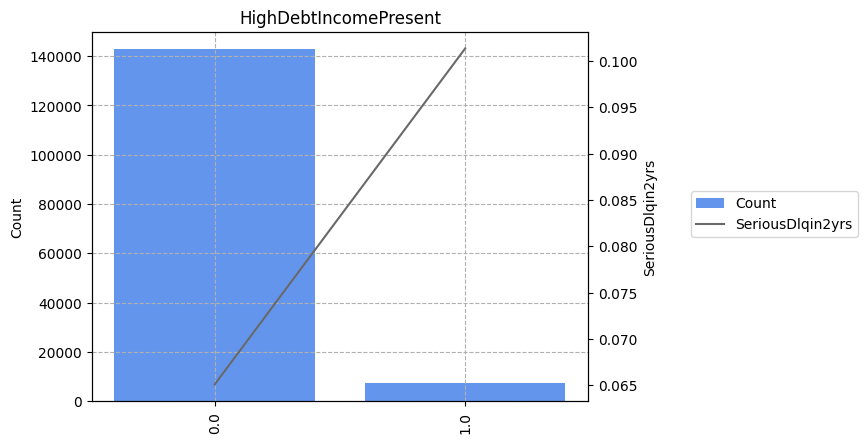

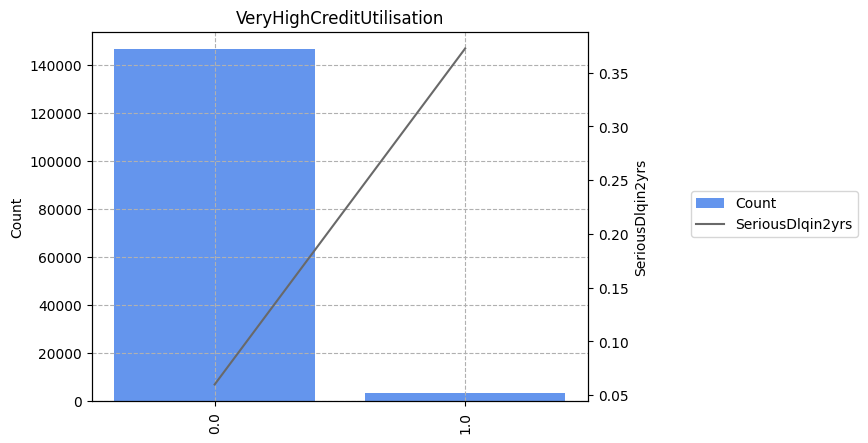

In [41]:
get_equi_frequency_plot(data=train_data, features=pred_col, col_target=def_col)

# Learnings
## (from equi-frequency plots)
- Number of dependents, Credit line utilization and dpd variables show a clear increasing trend in delinquency rates
- Monthly income and age show a clear decreasing trend in delinquency rates
- For DebtRatio, the delinquency rates increase till DebtRatio is less than 4, then it decreases


# New feature engineering

In [42]:
def preprocess(data):
    # Combining dpd columns (since they are highly correlated anyway)
    dpd_columns = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']
    data['NumberOfTimeGreaterThan30DPD'] = data[dpd_columns].sum(axis=1)

    # Allocation of monthly income amount to each dependent person (including self)
    data['MonthlyIncomePerDependent'] = data['MonthlyIncome'] / (data['NumberOfDependents'] + 1)

    # Income allocation per open credit line or loan (adding 1 to number of credit lines to prevent presence of unwanted infinities in the data)
    data['MonthlyIncomePerCreditLine'] = data['MonthlyIncome'] / (data['NumberOfOpenCreditLinesAndLoans'] + 1)
    return data

train_data = preprocess(data=train_data)



In [43]:
pred_col.append('NumberOfTimeGreaterThan30DPD')
pred_col.append('MonthlyIncomePerDependent')
pred_col.append('MonthlyIncomePerCreditLine')
pred_col.remove('NumberOfTime30-59DaysPastDueNotWorse')
pred_col.remove('NumberOfTime60-89DaysPastDueNotWorse')
pred_col.remove('NumberOfTimes90DaysLate')

In [44]:
train_data.drop('equi_frequency_bracket', axis=1, inplace=True)

In [45]:
# get_equi_frequency_plot(data=train_data, features=[x for x in train_data.columns if x != def_col], col_target=def_col)

In [46]:
train_data[pred_col].head(3)

,age,MonthlyIncome,NumberOfDependents,NumberRealEstateLoansOrLines,NumberOfOpenCreditLinesAndLoans,DebtRatio,RevolvingUtilizationOfUnsecuredLines,HighDebtIncomePresent,VeryHighCreditUtilisation,NumberOfTimeGreaterThan30DPD,MonthlyIncomePerDependent,MonthlyIncomePerCreditLine
1,45,9120.0,2.0,6,13,0.802982,0.766127,0,0,2,3040.0,651.428571
2,40,2600.0,1.0,0,4,0.121876,0.957151,0,0,0,1300.0,520.000000
3,38,3042.0,0.0,0,2,0.085113,0.658180,0,0,2,3042.0,1014.000000


In [47]:
test_data = preprocess(data=test_data)
test_data[pred_col].head(3)

,age,MonthlyIncome,NumberOfDependents,NumberRealEstateLoansOrLines,NumberOfOpenCreditLinesAndLoans,DebtRatio,RevolvingUtilizationOfUnsecuredLines,HighDebtIncomePresent,VeryHighCreditUtilisation,NumberOfTimeGreaterThan30DPD,MonthlyIncomePerDependent,MonthlyIncomePerCreditLine
1,43,5700.0,0.0,0,4,0.177513,0.885519,0,0,0,5700.000000,1140.0000
2,57,9141.0,2.0,4,15,0.527237,0.463295,0,0,0,3047.000000,571.3125
3,59,5083.0,2.0,1,12,0.687648,0.043275,0,0,0,1694.333333,391.0000


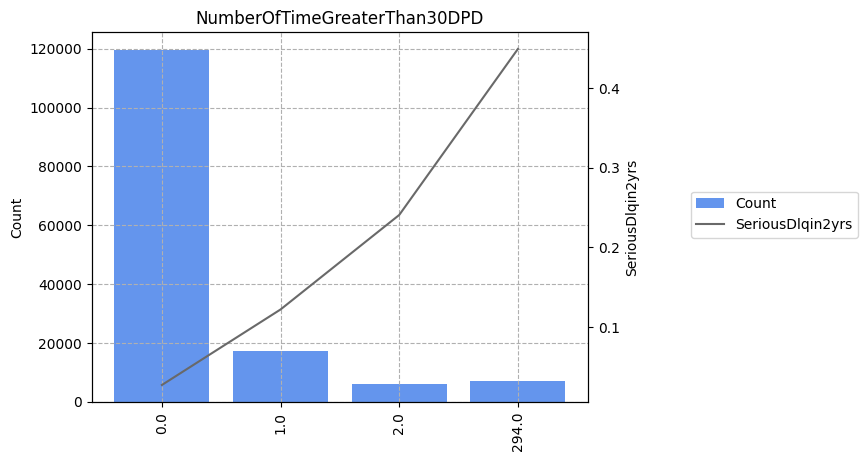

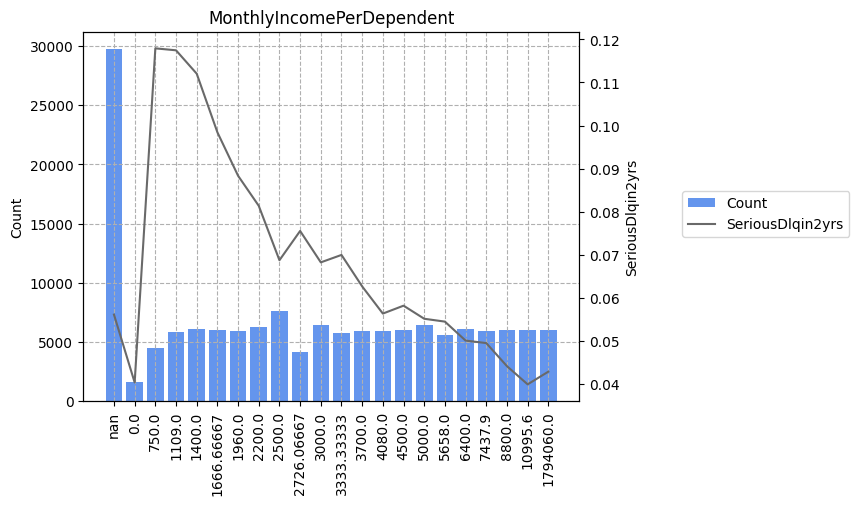

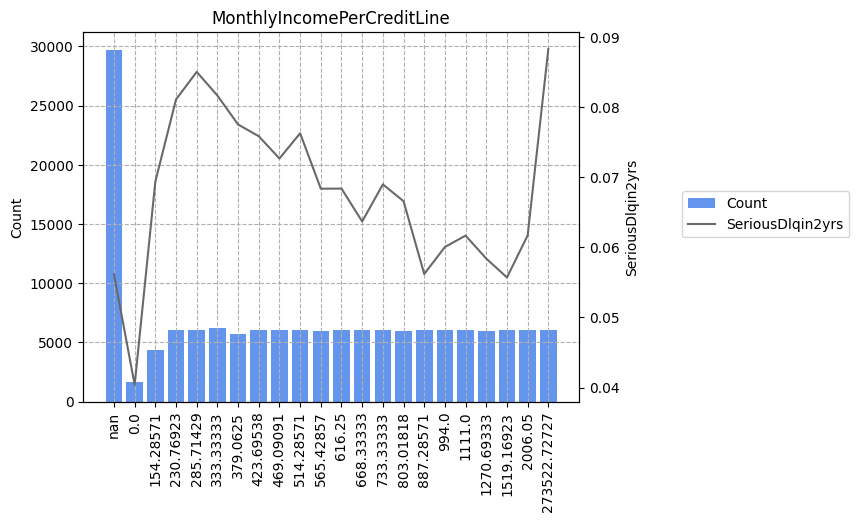

In [48]:
get_equi_frequency_plot(data=train_data, features=['NumberOfTimeGreaterThan30DPD', 'MonthlyIncomePerDependent', 'MonthlyIncomePerCreditLine'], col_target=def_col)

<Axes: >

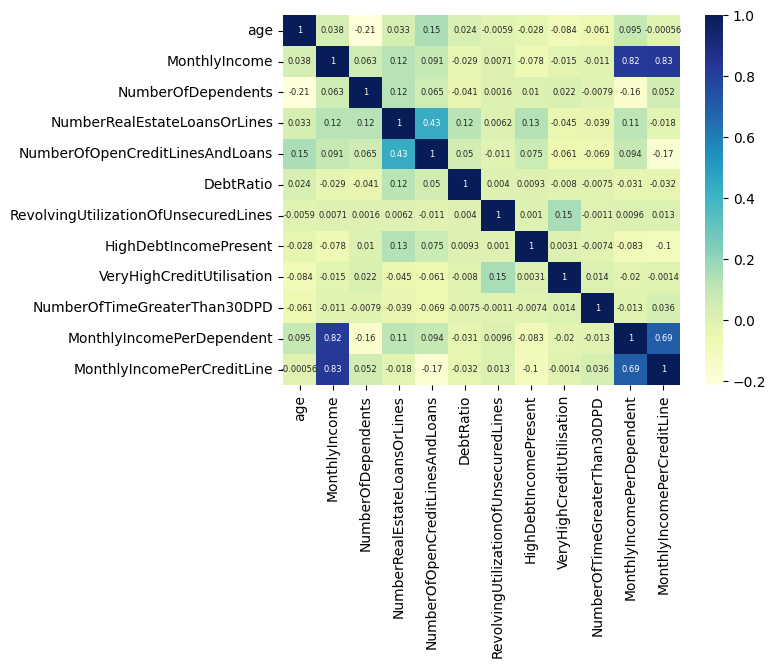

In [49]:
sns.heatmap(data=train_data[pred_col].corr(), annot=True, cmap="YlGnBu", annot_kws={'fontsize': 6})

## Single prediction auc values

In [50]:
auc_dict = {}
for col in pred_col:
    temp = train_data[train_data[col].notna()]
    auc_dict[col] = abs(2 * roc_auc_score(y_true=temp[def_col], y_score=temp[col]) - 1)

auc_df = pd.DataFrame(auc_dict, index=['gini']).T.sort_values('gini', ascending=False)
auc_df.style.background_gradient()

,gini
RevolvingUtilizationOfUnsecuredLines,0.555502
NumberOfTimeGreaterThan30DPD,0.551720
age,0.270502
MonthlyIncomePerDependent,0.187906
MonthlyIncome,0.152077
VeryHighCreditUtilisation,0.108491
NumberOfDependents,0.093548
NumberOfOpenCreditLinesAndLoans,0.089001
NumberRealEstateLoansOrLines,0.074643
DebtRatio,0.047614


In [51]:
auc_df.reset_index(inplace=True)
auc_df.rename(columns={'index': 'features'}, inplace=True)

In [52]:
round(auc_df['gini'] , 2)

0     0.56
1     0.55
2     0.27
3     0.19
4     0.15
5     0.11
6     0.09
7     0.09
8     0.07
9     0.05
10    0.04
11    0.03
Name: gini, dtype: float64

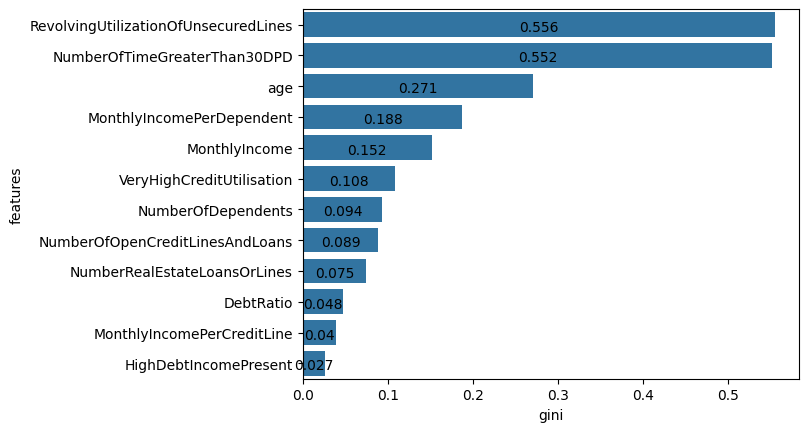

In [53]:
ax = sns.barplot(data=auc_df, y='features', x='gini')
for i, v in enumerate(round(auc_df['gini'], 3).tolist()):
   ax.text(v/2,i+0.2, str(v), ha='center')
plt.show()

# Learnings
- Credit utilization has the greatest predictive value
- The combined dpd column has second highest predictive value (Success!!!)
- The VeryHighCreditUtilisation flag has high predictive value (Success!!!)
- Monthly Income per dependent has pretty low predictive value (Oops!!!)
- Similarly, HighDebtIncomePresent has pretty low predictive value (Oops!!!)

In [54]:
auc_df

,features,gini
0,RevolvingUtilizationOfUnsecuredLines,0.555502
1,NumberOfTimeGreaterThan30DPD,0.551720
2,age,0.270502
3,MonthlyIncomePerDependent,0.187906
4,MonthlyIncome,0.152077
5,VeryHighCreditUtilisation,0.108491
6,NumberOfDependents,0.093548
7,NumberOfOpenCreditLinesAndLoans,0.089001
8,NumberRealEstateLoansOrLines,0.074643
9,DebtRatio,0.047614


In [55]:
# sorting features in decreasing order of auc score for convenience
pred_col = auc_df.features.tolist()

# Training the model

In [56]:
pred_col

['RevolvingUtilizationOfUnsecuredLines',
 'NumberOfTimeGreaterThan30DPD',
 'age',
 'MonthlyIncomePerDependent',
 'MonthlyIncome',
 'VeryHighCreditUtilisation',
 'NumberOfDependents',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberRealEstateLoansOrLines',
 'DebtRatio',
 'MonthlyIncomePerCreditLine',
 'HighDebtIncomePresent']

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(train_data[pred_col], train_data[def_col], test_size=0.33, random_state=RANDOM_STATE)
X_train.shape[0], X_test.shape[0], Y_train.shape[0], Y_test.shape[0]

(100500, 49500, 100500, 49500)

In [58]:
neg_pos_ratio = (100 - def_percent)/ def_percent
neg_pos_ratio

13.970059880239521

In [59]:
def modelfit(model, X_train, y_train, X_test, y_test, cv_folds=5, early_stopping_rounds=10):
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    cvresult = xgb.cv(
        params=model.get_xgb_params(), 
        dtrain=dtrain, 
        num_boost_round=model.get_params()['n_estimators'], 
        nfold=cv_folds, 
        metrics='auc', 
        early_stopping_rounds=early_stopping_rounds
    )
    model.set_params(n_estimators=cvresult.shape[0])
    print(f"Optimum value for n_estimators: {cvresult.shape[0]}")

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    train_prob = model.predict_proba(X_train)[:,1]
    test_prob = model.predict_proba(X_test)[:,1]

    print(f"AUC Score (Train): {roc_auc_score(y_train, train_prob) * 100}")
    print(f"AUC Score (Test): {roc_auc_score(y_test, test_prob) * 100}")
                    
    feat_imp = pd.DataFrame(model.feature_importances_, columns=['importance'], index=X_train.columns).sort_values('importance', ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [60]:
# model = XGBClassifier(
#         learning_rate=0.05,
#         n_estimators=500,
#         colsample_bytree=0.8,
#         subsample=0.8,
#         max_depth=5,
#         min_child_weight=1,
#         reg_alpha=0,
#         early_stopping_rounds=10,
#         seed=RANDOM_STATE,
#         scale_pos_weight=neg_pos_ratio,
#         objective= 'binary:logistic',
#         eval_metric='auc',
#         nthread=-1
#         )

# cvresult = xgb.cv(
#         params=model.get_xgb_params(), 
#         dtrain=xgb.DMatrix(X_train.values, label=Y_train.values), 
#         num_boost_round=model.get_params()['n_estimators'], 
#         nfold=5, 
#         metrics='auc', 
#         early_stopping_rounds=10
#     )

In [61]:
# cvresult

Optimum value for n_estimators: 87
AUC Score (Train): 87.45364177385285
AUC Score (Test): 86.58419937514374


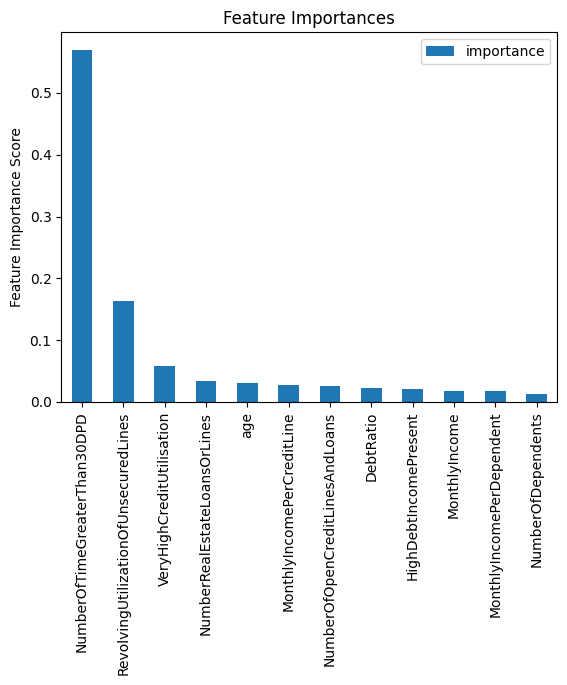

In [62]:
model = XGBClassifier(
        learning_rate=0.05,
        n_estimators=500,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=5,
        min_child_weight=1,
        reg_alpha=0,
        early_stopping_rounds=10,
        seed=RANDOM_STATE,
        scale_pos_weight=neg_pos_ratio,
        objective= 'binary:logistic',
        eval_metric='auc',
        nthread=-1
        )

modelfit(model, X_train, Y_train, X_test, Y_test)

# Learnings
## (from the base model score training)
- optimum value for n_estimators is 77 at learning rate of 0.05
- NumberOfTimesGreaterThan30DPD has the highest feature importance
- Credit utilization has the second highest feature importance
- Debt ratio and number of dependents has the lowest feature importance


# Hyperparameter tuning parameters

In [63]:
N_ESTIMATORS = 82

In [64]:
model1 = XGBClassifier(
    learning_rate=0.05,
    n_estimators=N_ESTIMATORS,
    colsample_bytree=0.8,
    subsample=0.8,
    max_depth=5,
    min_child_weight=1,
    reg_alpha=0,
    early_stopping_rounds=10,
    seed=RANDOM_STATE,
    scale_pos_weight=neg_pos_ratio,
    objective= 'binary:logistic',
    nthread=-1
)

param_test1 = {
 'max_depth':range(1,6,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(
    estimator=model1, 
    param_grid=param_test1, 
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gsearch1.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=False)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.05, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
         

In [65]:
gsearch1.best_score_, gsearch1.best_params_

(0.8606945266529553, {'max_depth': 5, 'min_child_weight': 5})

In [66]:
model2 = XGBClassifier(
    learning_rate=0.05,
    n_estimators=N_ESTIMATORS,
    colsample_bytree=0.8,
    subsample=0.8,
    max_depth=5,
    min_child_weight=5,
    reg_alpha=0,
    early_stopping_rounds=10,
    seed=RANDOM_STATE,
    scale_pos_weight=neg_pos_ratio,
    objective= 'binary:logistic',
    nthread=-1
)

param_test2 = {
 'max_depth':[4, 5, 6],
 'min_child_weight': [4, 5, 6]
}

gsearch2 = GridSearchCV(
    estimator=model2, 
    param_grid=param_test2, 
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gsearch2.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=False)
gsearch2.best_score_, gsearch2.best_params_

(0.8608670476078994, {'max_depth': 5, 'min_child_weight': 6})

In [67]:
MAX_DEPTH = 5
MIN_CHILD_WEIGHT = 6

In [68]:
model3 = XGBClassifier(
    learning_rate=0.05,
    n_estimators=N_ESTIMATORS,
    colsample_bytree=0.8,
    subsample=0.8,
    max_depth=MAX_DEPTH,
    min_child_weight=MIN_CHILD_WEIGHT,
    reg_alpha=0,
    early_stopping_rounds=10,
    seed=RANDOM_STATE,
    scale_pos_weight=neg_pos_ratio,
    objective= 'binary:logistic',
    nthread=-1
)

param_test3 = {
 'gamma': [i/10 for i in range(5)]
}

gsearch3 = GridSearchCV(
    estimator=model3, 
    param_grid=param_test3, 
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gsearch3.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=False)
gsearch3.best_score_, gsearch3.best_params_

(0.8608693048220989, {'gamma': 0.3})

In [69]:
GAMMA = 0.2

Optimum value for n_estimators: 87
AUC Score (Train): 87.58008049599424
AUC Score (Test): 86.57857832360568


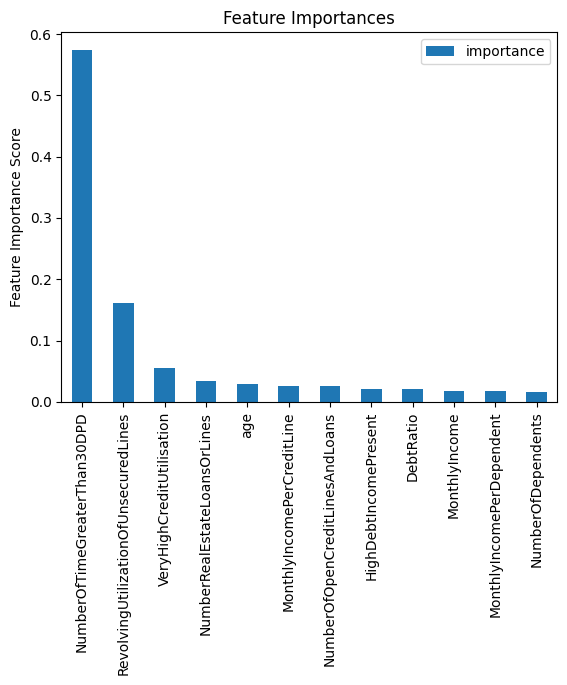

In [70]:
model3 = XGBClassifier(
    learning_rate=0.05,
    n_estimators=500,
    colsample_bytree=0.8,
    subsample=0.8,
    max_depth=MAX_DEPTH,
    min_child_weight=MIN_CHILD_WEIGHT,
    gamma=GAMMA,
    early_stopping_rounds=10,
    seed=RANDOM_STATE,
    scale_pos_weight=neg_pos_ratio,
    objective= 'binary:logistic',
    nthread=-1
)

modelfit(model3, X_train, Y_train, X_test, Y_test)

In [71]:
N_ESTIMATORS = 96

In [72]:
model4 = XGBClassifier(
    learning_rate=0.05,
    n_estimators=N_ESTIMATORS,
    colsample_bytree=0.8,
    subsample=0.8,
    max_depth=MAX_DEPTH,
    min_child_weight=MIN_CHILD_WEIGHT,
    gamma=GAMMA,
    early_stopping_rounds=10,
    seed=RANDOM_STATE,
    scale_pos_weight=neg_pos_ratio,
    objective= 'binary:logistic',
    nthread=-1
)

param_test4 = {
 'subsample':[i/10 for i in range(2,11,2)],
 'colsample_bytree':[i/10 for i in range(4,11,2)]
}

gsearch4 = GridSearchCV(
    estimator=model4, 
    param_grid=param_test4, 
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gsearch4.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=False)
gsearch4.best_score_, gsearch4.best_params_

(0.8619191045721886, {'colsample_bytree': 0.6, 'subsample': 0.6})

In [73]:
model5 = XGBClassifier(
    learning_rate=0.05,
    n_estimators=N_ESTIMATORS,
    colsample_bytree=0.6,
    subsample=0.8,
    max_depth=MAX_DEPTH,
    min_child_weight=MIN_CHILD_WEIGHT,
    gamma=GAMMA,
    early_stopping_rounds=10,
    seed=RANDOM_STATE,
    scale_pos_weight=neg_pos_ratio,
    objective= 'binary:logistic',
    nthread=-1
)

param_test5 = {
 'subsample':[i/100 for i in range(70, 95, 5)],
 'colsample_bytree':[i/100 for i in range(50, 75, 5)]
}

gsearch5 = GridSearchCV(
    estimator=model5, 
    param_grid=param_test5, 
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gsearch5.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=False)
gsearch5.best_score_, gsearch5.best_params_

(0.8619970335710792, {'colsample_bytree': 0.6, 'subsample': 0.75})

In [74]:
COLSAMPLE_BYTREE = 0.6
SUBSAMPLE = 0.85

In [75]:
model6 = XGBClassifier(
    learning_rate=0.05,
    n_estimators=N_ESTIMATORS,
    colsample_bytree=COLSAMPLE_BYTREE,
    subsample=SUBSAMPLE,
    max_depth=MAX_DEPTH,
    min_child_weight=MIN_CHILD_WEIGHT,
    gamma=GAMMA,
    early_stopping_rounds=10,
    seed=RANDOM_STATE,
    scale_pos_weight=neg_pos_ratio,
    objective= 'binary:logistic',
    nthread=-1
)

param_test6 = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}

gsearch6 = GridSearchCV(
    estimator=model6, 
    param_grid=param_test6, 
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gsearch6.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=False)
gsearch6.best_score_, gsearch6.best_params_

(0.8619381590073228, {'reg_alpha': 1})

In [76]:
REG_ALPHA = 0.01

Optimum value for n_estimators: 95
AUC Score (Train): 87.65717808837674
AUC Score (Test): 86.62925852882455


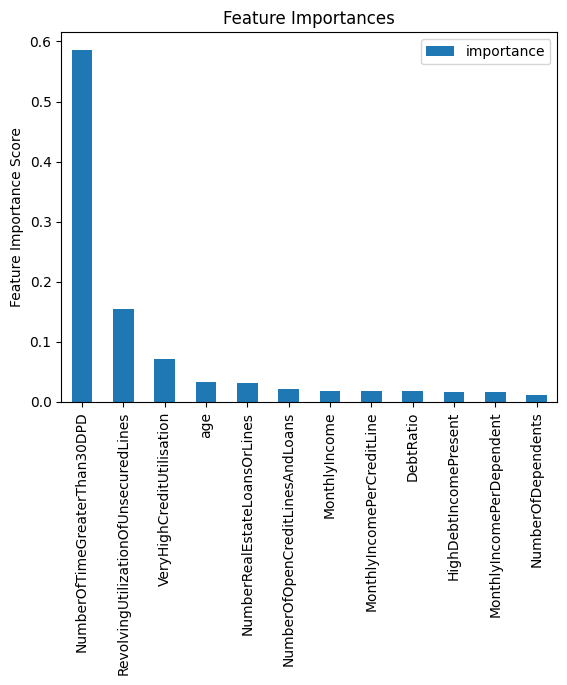

In [77]:
model7 = XGBClassifier(
    learning_rate=0.05,
    n_estimators=500,
    colsample_bytree=COLSAMPLE_BYTREE,
    subsample=SUBSAMPLE,
    max_depth=MAX_DEPTH,
    min_child_weight=MIN_CHILD_WEIGHT,
    gamma=GAMMA,
    reg_alpha=REG_ALPHA,
    early_stopping_rounds=10,
    seed=RANDOM_STATE,
    scale_pos_weight=neg_pos_ratio,
    objective= 'binary:logistic',
    nthread=-1
)

modelfit(model7, X_train, Y_train, X_test, Y_test)

# Learnings
- model7 is performing the best overall

Optimum value for n_estimators: 137
AUC Score (Train): 86.88014688687659
AUC Score (Test): 86.44822686240353


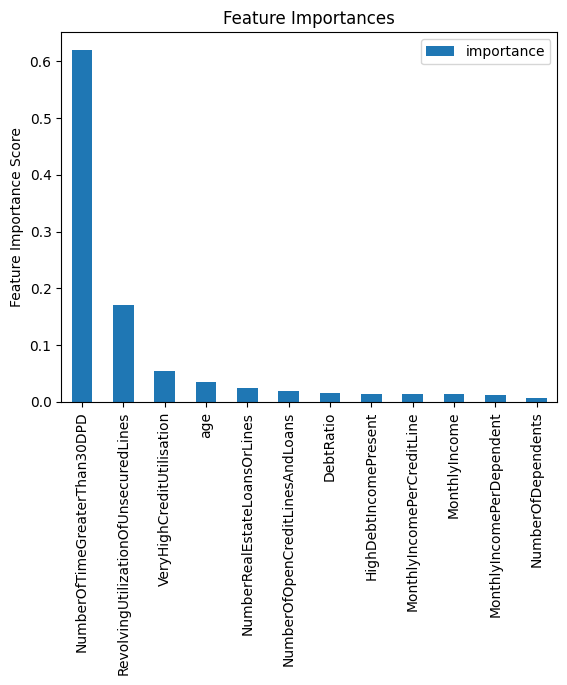

In [78]:
model8 = XGBClassifier(
    learning_rate=0.01,
    n_estimators=1000,
    colsample_bytree=COLSAMPLE_BYTREE,
    subsample=SUBSAMPLE,
    max_depth=MAX_DEPTH,
    min_child_weight=MIN_CHILD_WEIGHT,
    gamma=GAMMA,
    reg_alpha=REG_ALPHA,
    early_stopping_rounds=10,
    seed=RANDOM_STATE,
    scale_pos_weight=neg_pos_ratio,
    objective= 'binary:logistic',
    nthread=-1
)

modelfit(model8, X_train, Y_train, X_test, Y_test)

Optimum value for n_estimators: 148
AUC Score (Train): 87.41466597041313
AUC Score (Test): 86.67809606169061


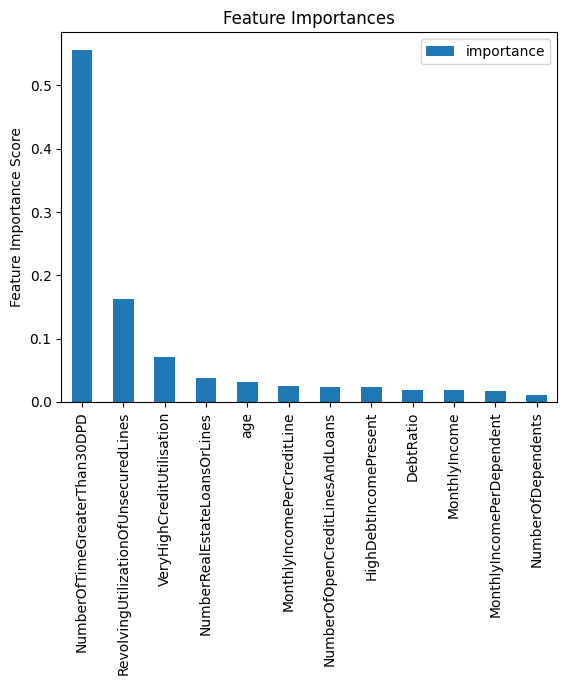

In [79]:
model9 = XGBClassifier(
    learning_rate=0.05,
    n_estimators=500,
    colsample_bytree=0.8,
    subsample=0.8,
    max_depth=4,
    min_child_weight=4,
    gamma=0,
    reg_alpha=0.01,
    early_stopping_rounds=10,
    seed=RANDOM_STATE,
    scale_pos_weight=neg_pos_ratio,
    objective= 'binary:logistic',
    nthread=-1
)

modelfit(model9, X_train, Y_train, X_test, Y_test)

In [80]:
print(f"AUC Score (Train): 87.44378971286388%")
print(f"AUC Score (Test): 86.65277692459775%")

AUC Score (Train): 87.44378971286388%
AUC Score (Test): 86.65277692459775%


Optimum value for n_estimators: 707
AUC Score (Train): 87.37817178223915
AUC Score (Test): 86.65722947617448


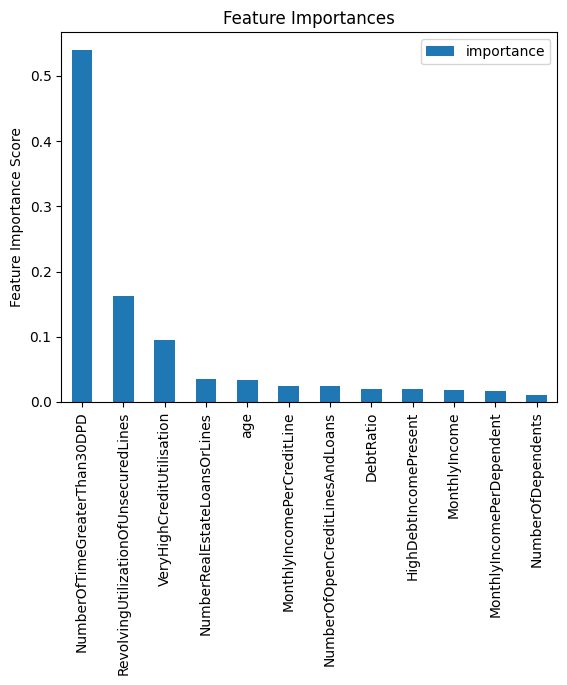

In [81]:
model10 = XGBClassifier(
    learning_rate=0.01,
    n_estimators=707,
    colsample_bytree=0.8,
    subsample=0.8,
    max_depth=4,
    min_child_weight=4,
    gamma=0,
    early_stopping_rounds=10,
    seed=RANDOM_STATE,
    scale_pos_weight=neg_pos_ratio,
    objective= 'binary:logistic',
    nthread=-1
)

modelfit(model10, X_train, Y_train, X_test, Y_test)

Optimum value for n_estimators: 130
AUC Score (Train): 87.28533088035391
AUC Score (Test): 86.67405004458317


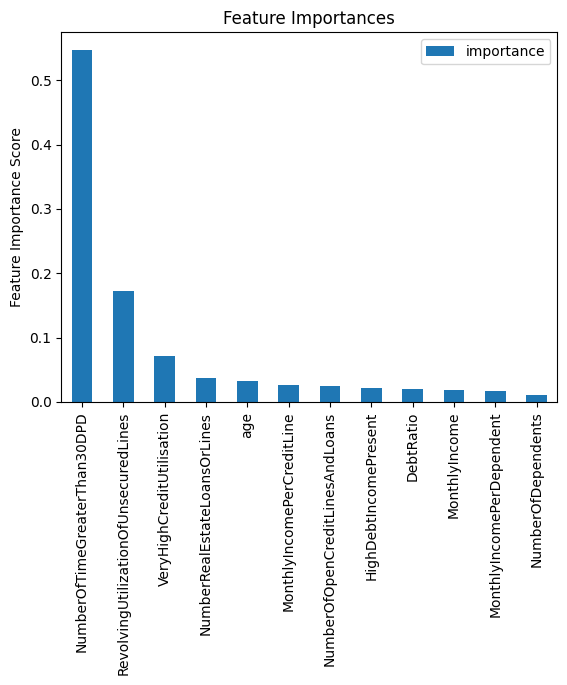

In [82]:
model11 = XGBClassifier(
    learning_rate=0.05,
    n_estimators=130,
    colsample_bytree=0.8,
    subsample=0.8,
    max_depth=4,
    min_child_weight=4,
    gamma=0,
    reg_alpha=0,
    early_stopping_rounds=10,
    seed=RANDOM_STATE,
    scale_pos_weight=neg_pos_ratio,
    objective= 'binary:logistic',
    nthread=-1
)

modelfit(model11, X_train, Y_train, X_test, Y_test)

# Learnings
- Model 10 performs the best according to auc score

In [83]:
train_data['score_probability_model7'] = model7.predict_proba(train_data[pred_col])[:,1]
# train_data['score_probability_model11'] = model11.predict_proba(train_data[pred_col])[:,1]

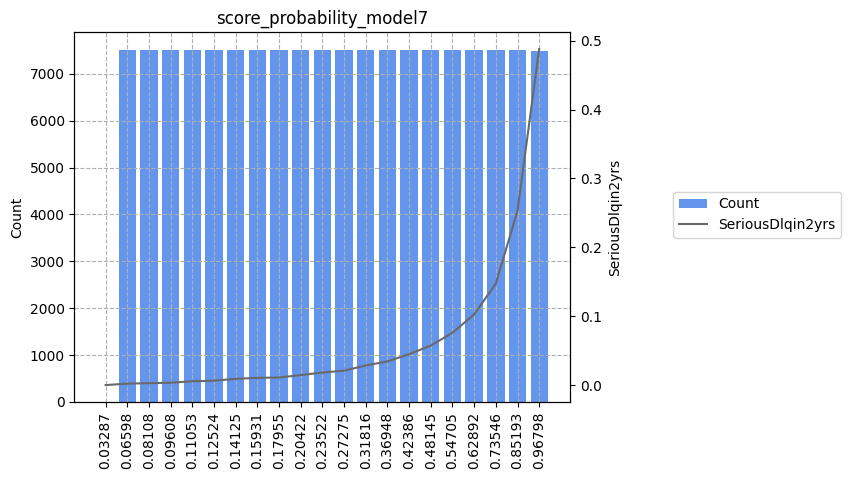

In [84]:
get_equi_frequency_plot(data=train_data, features=['score_probability_model7'], col_target=def_col)

# Learnings
- Both model 10 and model 11 have very good risk segmentation based on score probabilities
- Hence, since model 10 has the highest auc, we choose this score probability as the best

In [89]:
import shap
explainer = shap.Explainer(model7)
shap_values = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


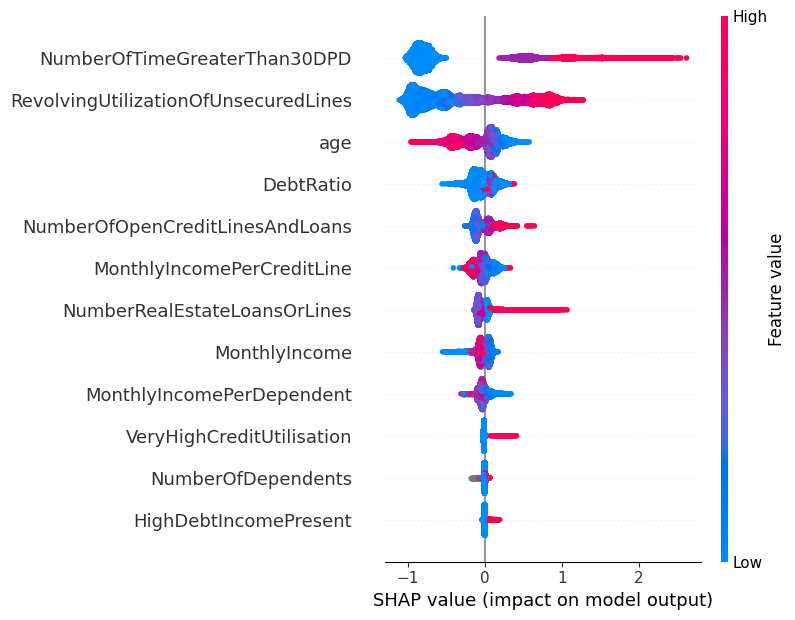

In [ ]:
shap.summary_plot(shap_values, X_test)

Saving the Pickle File

In [91]:
import pickle 
pickle_out = open("classifier.pkl", "wb") 
pickle.dump(model7, pickle_out) 
pickle_out.close()